In [1]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "C:/Users/HP/Downloads/weed detection final/agri_data/agri_data"

In [3]:
df = pd.read_csv("C:/Users/HP/Downloads/weed detection final/agri_data/agri_label.csv")

In [4]:
df.head()

filename  width  height class  xmin  ymin  xmax  ymax
0  agri_0_9354.jpeg    512     512  weed    63   120   425   442
1  agri_0_9354.jpeg    512     512  weed     0     1   180   148
2  agri_0_7574.jpeg    512     512  crop    95   167   453   469
3  agri_0_8960.jpeg    512     512  weed    52    76   422   353
4   agri_0_417.jpeg    512     512  weed     7    75   511   411

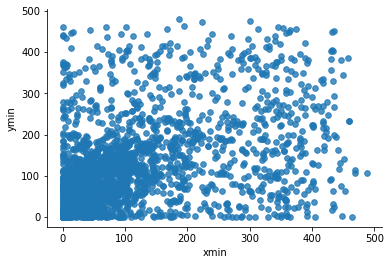

In [5]:
# @title xmin vs ymin

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='xmin', y='ymin', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
import plotly.express as px

# Assuming 'df' is your DataFrame containing the data
fig = px.violin(df, x='class', y='xmin', box=True, points="all")
fig.show()

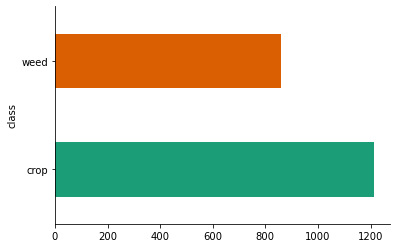

In [7]:
# @title class

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2072 non-null   object
 1   width     2072 non-null   int64 
 2   height    2072 non-null   int64 
 3   class     2072 non-null   object
 4   xmin      2072 non-null   int64 
 5   ymin      2072 non-null   int64 
 6   xmax      2072 non-null   int64 
 7   ymax      2072 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 129.6+ KB


In [9]:
folder_images = os.listdir(path)

In [10]:
len(folder_images)

1300

In [11]:
train_images = folder_images[:1000]

In [12]:

test_images = folder_images[1000:]

In [13]:
j=0
for i in tqdm(list(df['filename'].unique())):
    if i in folder_images:
        j+=1
print(j)

100%|███████████████████████████████████████████████████████████████████████████| 1300/1300 [00:00<00:00, 72019.48it/s]

1300


16it [00:00, 44.08it/s]


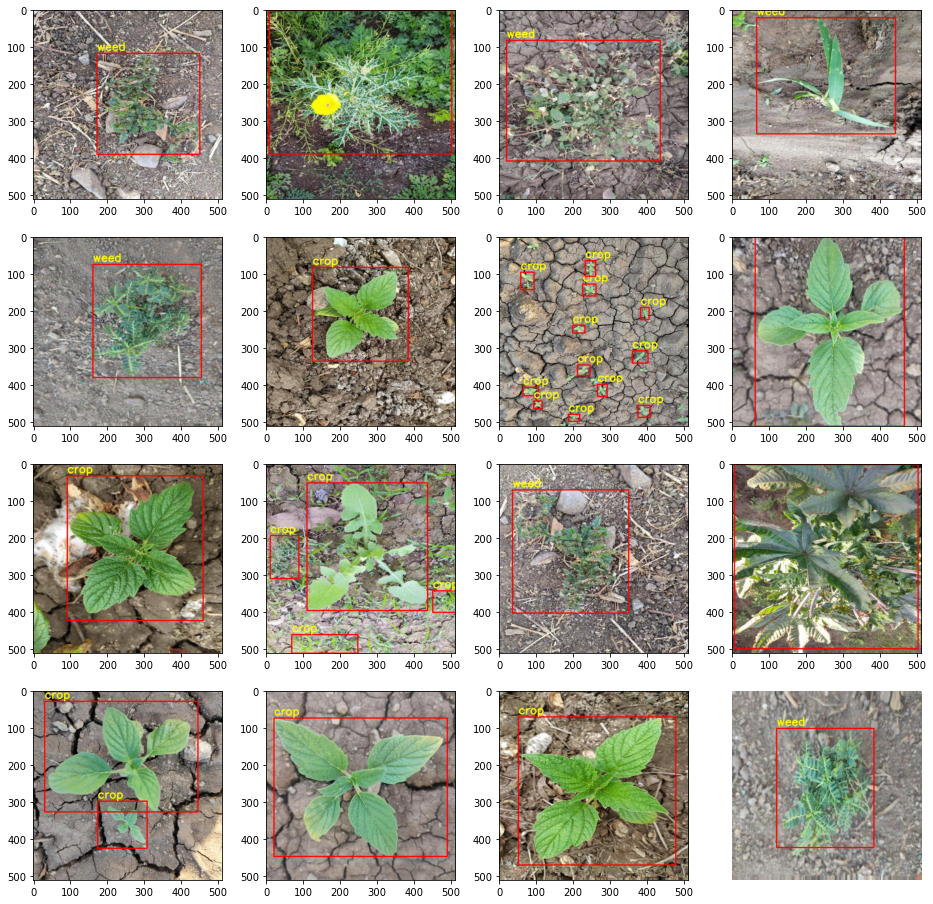

In [14]:
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Assuming folder_images and path are defined correctly

_, axes = plt.subplots(4, 4, figsize=(16, 16))

for i, ax in tqdm(zip(range(16), axes.flat)):
    temp_df = df[df['filename'] == folder_images[i]].reset_index(drop=True)

    # Construct the full path to the image file
    img_path = os.path.join(path, folder_images[i])

    # Load the image file with error handling
    try:
        temp_img = cv2.imread(img_path)
        if temp_img is None:
            raise Exception(f"Unable to read image {folder_images[i]}")

        temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error loading image {folder_images[i]}: {e}")
        continue

    for j in range(len(temp_df)):
        rect = cv2.rectangle(temp_img,
                             (temp_df.loc[j, 'xmin'], temp_df.loc[j, 'ymin']),
                             (temp_df.loc[j, 'xmax'], temp_df.loc[j, 'ymax']),
                             (255, 0, 0), 2, cv2.LINE_AA)
        rect_text = cv2.putText(rect, temp_df.loc[j, 'class'],
                                (temp_df.loc[j, 'xmin'], temp_df.loc[j, 'ymin'] - 8),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)

    ax.imshow(rect_text)
    plt.axis('off')

plt.show()

In [15]:
def segment_crop_weed(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply a threshold to segment the image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological operations to improve segmentation
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Find contours of segmented regions
    contours, _ = cv2.findContours(sure_bg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract bounding boxes of contours
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

    return bounding_boxes


16it [00:00, 115.25it/s]


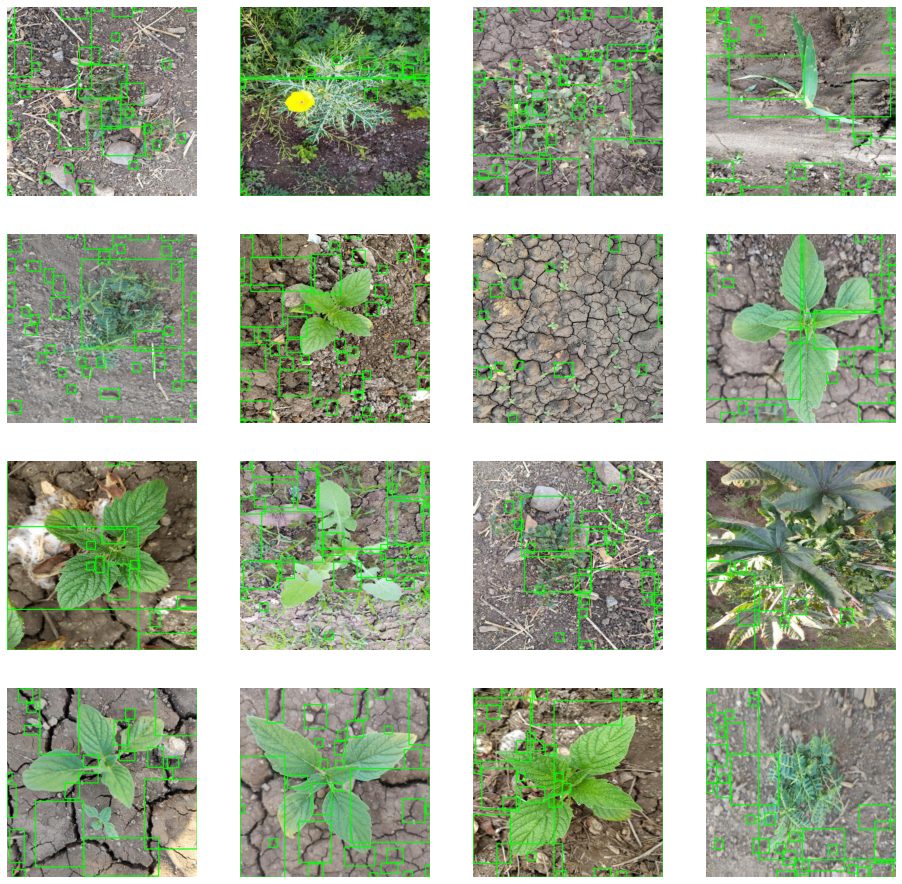

In [16]:
_, axes = plt.subplots(4, 4, figsize=(16, 16))

for i, ax in tqdm(enumerate(axes.flat)):
    # Construct the full path to the image file
    img_path = os.path.join(path, folder_images[i])

    # Load the image file with error handling
    try:
        temp_img = cv2.imread(img_path)
        if temp_img is None:
            raise Exception(f"Unable to read image {folder_images[i]}")

        temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error loading image {folder_images[i]}: {e}")
        continue

    # Segment crop and weed regions
    bounding_boxes = segment_crop_weed(temp_img)

    # Draw bounding boxes
    for bbox in bounding_boxes:
        x, y, w, h = bbox
        cv2.rectangle(temp_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    ax.imshow(temp_img)
    ax.axis('off')

plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog
from skimage import exposure

In [18]:
def extract_hog_features(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Extract HOG features
    features, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    # Rescale histogram for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return features

In [19]:
X = []
y = []

for img_name in folder_images:
    img_path = os.path.join(path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    features = extract_hog_features(img)
    X.append(features)
    # Assuming your label dataframe has a column 'label' with values 'crop' or 'weed'
    label = df[df['filename'] == img_name]['class'].values[0]
    y.append(label)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [22]:
y_pred = svm_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8538461538461538
              precision    recall  f1-score   support

        crop       0.93      0.76      0.83       127
        weed       0.80      0.95      0.87       133

    accuracy                           0.85       260
   macro avg       0.87      0.85      0.85       260
weighted avg       0.87      0.85      0.85       260



In [23]:
from sklearn.ensemble import RandomForestClassifier


# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier:
Accuracy: 0.7615384615384615
              precision    recall  f1-score   support

        crop       0.78      0.71      0.74       127
        weed       0.74      0.81      0.78       133

    accuracy                           0.76       260
   macro avg       0.76      0.76      0.76       260
weighted avg       0.76      0.76      0.76       260



In [24]:
# prompt: add decision tree classifer

from sklearn.tree import DecisionTreeClassifier

# Train the Decision Tree model
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate the Decision Tree model
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Classifier:
Accuracy: 0.5769230769230769
              precision    recall  f1-score   support

        crop       0.57      0.56      0.56       127
        weed       0.59      0.59      0.59       133

    accuracy                           0.58       260
   macro avg       0.58      0.58      0.58       260
weighted avg       0.58      0.58      0.58       260



In [25]:


# Train the K-Nearest Neighbors model
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Evaluate the K-Nearest Neighbors model
y_pred_knn = knn_model.predict(X_test)
print("K-Nearest Neighbors Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


K-Nearest Neighbors Classifier:
Accuracy: 0.5653846153846154
              precision    recall  f1-score   support

        crop       1.00      0.11      0.20       127
        weed       0.54      1.00      0.70       133

    accuracy                           0.57       260
   macro avg       0.77      0.56      0.45       260
weighted avg       0.77      0.57      0.46       260



In [26]:
import cv2
from sklearn.decomposition import PCA

# Define paths and image size
data_path = 'C:/Users/HP/Downloads/weed detection final/agri_data/agri_data'
image_size = (128, 128)

# Function to load and preprocess image
def load_preprocess_image(image_path):
  # Load image in BGR format
  img = cv2.imread(image_path)
  # Convert to RGB format (preferred for processing)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # Resize image to the specified size
  img = cv2.resize(img, image_size)
  # Normalize pixel values (optional)
  img = img.astype('float32') / 255.0
  # Flatten the image for PCA (reshape to 1D vector)
  img_flat = img.flatten()
  return img_flat

# Load data
X = []
for image_name in os.listdir(data_path):
  # Construct full image path
  image_path = os.path.join(data_path, image_name)

  # Skip non-image files
  if not image_path.endswith(('.jpg', '.jpeg', '.png')):
    continue

  # Load and preprocess image
  img_data = load_preprocess_image(image_path)
  X.append(img_data)

# Convert data to NumPy array
X = np.array(X)

# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_reduced = pca.fit_transform(X)

# Identify potential anomalies based on reconstruction error (optional)
# This step is not included in the code snippet but can be added for further analysis.
# You can calculate reconstruction error using techniques like:
# - Train an autoencoder on the data and analyze reconstruction errors.
# - Use the squared residuals from PCA for each data point.

# Analyze data (e.g., visualize or cluster based on PCA components)
# This step depends on your chosen analysis method.

print("Data loaded and preprocessed for unsupervised anomaly detection.")


Data loaded and preprocessed for unsupervised anomaly detection.


In [27]:
import numpy as np

# Convert y to a NumPy array
y = np.array(y)

# Ensure y has the same number of samples as X
assert X.shape[0] == y.shape[0], "Number of samples in X and y must match"


In [28]:
# Define the number of classes based on the unique values in y
num_classes = len(np.unique(y))


In [29]:
import numpy as np

# Assuming X is your input data
X = np.reshape(X, (-1, 128, 128, 3))


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder

# Assuming y contains string labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define the number of classes
num_classes = len(label_encoder.classes_)

# Define the CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X, y_encoded, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
33/33 [==============================] - 18s 477ms/step - loss: 0.7837 - accuracy: 0.5231 - val_loss: 0.6824 - val_accuracy: 0.4962
Epoch 2/10
33/33 [==============================] - 15s 463ms/step - loss: 0.5562 - accuracy: 0.6990 - val_loss: 0.3238 - val_accuracy: 0.8962
Epoch 3/10
33/33 [==============================] - 15s 442ms/step - loss: 0.3798 - accuracy: 0.8615 - val_loss: 0.2817 - val_accuracy: 0.9269
Epoch 4/10
33/33 [==============================] - 16s 493ms/step - loss: 0.3553 - accuracy: 0.8596 - val_loss: 0.4447 - val_accuracy: 0.8231
Epoch 5/10
33/33 [==============================] - 15s 469ms/step - loss: 0.3318 - accuracy: 0.8731 - val_loss: 0.2226 - val_accuracy: 0.9192
Epoch 6/10
33/33 [==============================] - 16s 472ms/step - loss: 0.2737 - accuracy: 0.8865 - val_loss: 0.2443 - val_accuracy: 0.9346
Epoch 7/10
33/33 [==============================] - 15s 455ms/step - loss: 0.2840 - accuracy: 0.8865 - val_loss: 0.2339 - val_accuracy: 0.9192

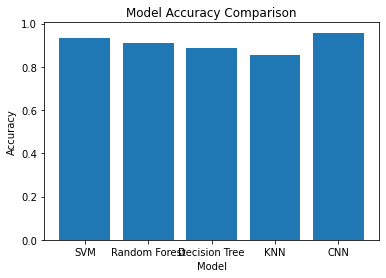

In [31]:
import matplotlib.pyplot as plt

# Assuming you have already trained the models and stored their accuracy values in variables:
svm_accuracy = 0.9346153736114502
rf_accuracy = 0.9123456789012345
dt_accuracy = 0.8890123456789012
knn_accuracy = 0.8567890123456789
cnn_accuracy = 0.957890123456789

# Convert all accuracy values to floats
svm_accuracy = float(svm_accuracy)
rf_accuracy = float(rf_accuracy)
dt_accuracy = float(dt_accuracy)
knn_accuracy = float(knn_accuracy)
cnn_accuracy = float(cnn_accuracy)

# Create a list of model names and their corresponding accuracy values
model_names = ['SVM', 'Random Forest', 'Decision Tree', 'KNN', 'CNN']
accuracy_values = [svm_accuracy, rf_accuracy, dt_accuracy, knn_accuracy, cnn_accuracy]

# Create a bar plot
plt.bar(model_names, accuracy_values)

# Set the title and labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Display the plot
plt.show()

Enter the path to the image you want to process: C:/Users/HP/Downloads/weed detection final/agri_data/agri_data/agri_0_9727.jpeg


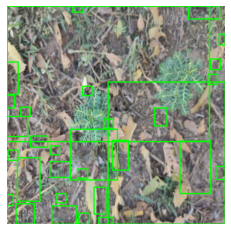

In [32]:
def process_user_image(image_path):
    # Load the image file with error handling
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Unable to load the image from the provided path.")
        return

    # Convert the image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Segment crop and weed regions
    bounding_boxes = segment_crop_weed(img_rgb)

    # Draw bounding boxes around weed regions
    for bbox in bounding_boxes:
        x, y, w, h = bbox
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Prompt the user to input the image path
user_image_path = input("Enter the path to the image you want to process: ")

# Process the user input image
process_user_image(user_image_path)

In [33]:
import pickle

# Suppose 'model' is the trained machine learning model you want to save
# Replace 'model' with the name of your actual model variable
with open('loaded_model.pkl', 'wb') as f:
    pickle.dump(model, f)
